In [1]:
import numpy as np
import xarray as xr
import cf_xarray as cfxr
import glob

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
import cmocean.cm as cm

from dask.distributed import Client

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39599/status,
Dashboard: /proxy/39599/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44203,Workers: 0
Dashboard: /proxy/39599/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39309,Total threads: 1
Dashboard: /proxy/40623/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:40325,


In [3]:
#Importing data

pathsC = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/outpu*/ocean/ocean.nc'))
pathsM = np.sort(glob.glob('/scratch/x77/jn8053/access-om2/archive/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126_prsc_rest/*/ocean/ocean.nc'))

In [4]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [5]:
depth = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['ht']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom5')

In [6]:
def preprocess(ds):
    ds = ds[['temp', 'salt']].where(shelf_mask == 1)
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [7]:
# Time slicing
cont = cont.sel(time=slice('1910-01-01','1919-12-31'))
melt = melt.sel(time=slice('1910-01-01','1919-12-31'))

In [8]:
saltC = cont['salt']
saltM = melt['salt']

tempC = cont['temp']
tempM = melt['temp']

In [9]:
import gsw

In [10]:
temp_anom = tempM - tempC
salt_anom = saltM - saltC

Next, we load cell area (denoted as $a(x,y,z)$) to construct the total ocean area as a function of depth, $A$, namely  

$A(z) = \sum_x \sum_y a(x,y,z)$

We load dxt and dyt and compute a masked version of cell area; we also use a slight hack to divide temperature by itself and thereby get a 3-dimensional cell area mask that is needed to create.

In [11]:
area = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['area_t']

# Correcting the area
var = cont['salt'].isel(time=0,st_ocean=0)
area_corr = area*(var*0 +1)

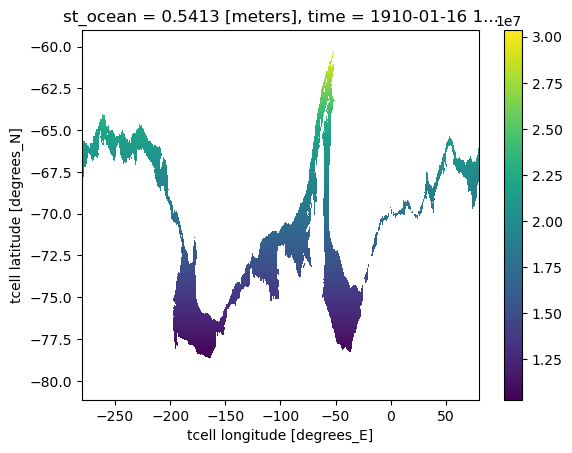

In [12]:
area_corr.plot()

In [13]:
# Taking the sum - control and melt areas are the same so only using control here.

shelf_area = area_corr.where(shelf_mask == 1).sum(['xt_ocean', 'yt_ocean']).load()

Now, the mean temperature at each time level can then be computed as

$T(z,t) = \frac{\sum_x \sum_y a(x,y,z) \, \tilde{\theta}(x,y,z,t)}{A(z)}$

where $T$ is the globally average temperature and $\tilde{\theta}$ is the anomaly of the conservative temperature.

In [14]:
temp_hov = (area_corr * temp_anom).sum(['xt_ocean', 'yt_ocean']) / shelf_area
salt_hov = (area_corr * salt_anom).sum(['xt_ocean', 'yt_ocean']) / shelf_area

In [15]:
temp_hov

<xarray.DataArray (time: 120, st_ocean: 75)> Size: 36kB
dask.array<truediv, shape=(120, 75), dtype=float32, chunksize=(2, 38), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 960B 1910-01-16 12:00:00 ... 1919-12-16 12:00:00

In [16]:
salt_hov

<xarray.DataArray (time: 120, st_ocean: 75)> Size: 36kB
dask.array<truediv, shape=(120, 75), dtype=float32, chunksize=(2, 38), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 960B 1910-01-16 12:00:00 ... 1919-12-16 12:00:00

In [ ]:
temp_hov = temp_hov.load()

In [ ]:
salt_hov = salt_hov.load()

In [ ]:
def plot_hovmoller_shelf(fsize = 14, date_format = mdates.DateFormatter('%Y')):
    
    # Set figures properties
    plt.rcParams['font.size'] = fsize
    plt.rcParams['xtick.labelsize'] = fsize-2
    plt.rcParams['ytick.labelsize'] = fsize-2
    
    fig = plt.figure(figsize=(10, 9))
    grid = GridSpec(100, 100)
    
    ax = [fig.add_subplot(grid[:30, :30]), fig.add_subplot(grid[:30, 33:63])]
    
    for i in range(len(ax)):
        ax[i].tick_params(axis='x')#, labelrotation=45)
        if i != 0 and i != 2:
            ax[i].set_yticklabels([]) 

    return fig, ax

In [ ]:
# Your original monthly time coordinates
# Original monthly time coordinates
time_vals = temp_hov.time.values
n_years = 10
months_per_year = 12

# Tick positions: start of each year
tick_positions = time_vals[::months_per_year].tolist()  # first month of each year

# Add the very last month as the final tick
tick_positions.append(time_vals[-1])

# Tick labels: 0, 1, ..., 10
tick_labels = np.arange(0, n_years + 1)

In [ ]:
#Shelf area plot

fig, ax = plot_hovmoller_shelf(fsize = 14)

levels_temperature = np.arange(-0.02, 0.0201, 0.0001)

cf_temp = temp_hov.cf.plot(ax = ax[0],
                                  levels = levels_temperature,
                                  x = 'time',
                                  y = 'st_ocean',
                                  add_colorbar = False,
                                  label = None,
                                  cmap = cm.balance)

levels_salinity = np.arange(-0.04, 0.041, 0.0001)

cf_salt = salt_hov.cf.plot(ax = ax[1],
                               levels = levels_salinity,
                               x = 'time',
                               y = 'st_ocean',
                               add_colorbar = False,
                               label = None,
                               cmap = cm.curl)

## Beautification details
for i in range(len(ax)):
    if i < 2:
        ax[i].set_xlabel("Time (years)")
        ax[i].set_ylim(900, 0)
        ax[i].set_xlim(500,4000)
    else:
        ax[i].set_xlabel("")
        ax[i].set_xlim(500,4000)
        ax[i].set_ylim(5000, 900)

# Apply to both axes
for ax_i in [ax[0], ax[1]]:
    ax_i.set_xticks(tick_positions)
    ax_i.set_xticklabels(tick_labels)

ax[0].set_ylabel("Depth (m)")

ax[1].set_ylabel("")

# Colorbars
bar = plt.axes([0.11, 0.99, 0.25, 0.02])
cbar_1 = plt.colorbar(cf_temp, cax = bar, orientation = 'horizontal', extend='both', format= '%.3f')  
cbar_1.set_label("Temperature [$\degree$C]")

bar = plt.axes([0.37, 0.99, 0.25, 0.02])
cbar_2 = plt.colorbar(cf_salt, cax = bar, orientation = 'horizontal', extend='both', format= '%.3f')  
cbar_2.set_label("Salinity [psu]")

for cbar in [cbar_1, cbar_2]:
    tick_locator = ticker.MaxNLocator(nbins=3) ## The ticker needs to called within the loop
    cbar.locator = tick_locator
    cbar.update_ticks()